In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [26]:
data = loadmat('ex4data1.mat')
X=data.get('X')
y=data.get('y')



In [27]:
def plot_100_image(X):
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]
    size = int(np.sqrt(X.shape[1]))
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(10, 10))

    plt.subplots_adjust(wspace=0.5,hspace=0.5) # 调整subplot之间的间距

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            ax_array[r,c].set_title(y[sample_idx[10*r+c]])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

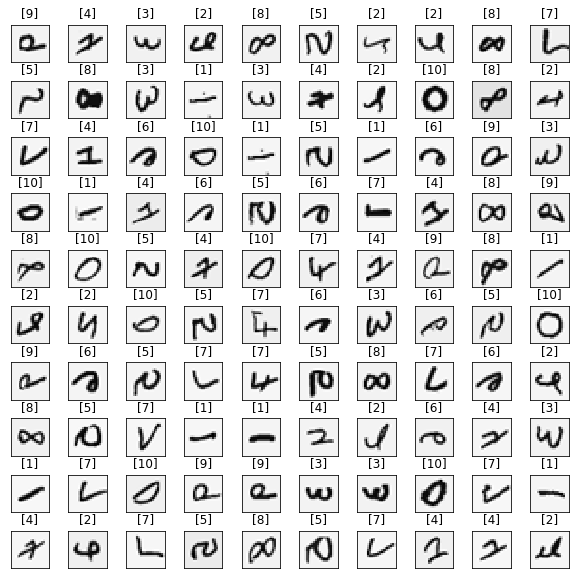

In [28]:
plot_100_image(X)

## 发现图像的x,y坐标轴需要调换一下

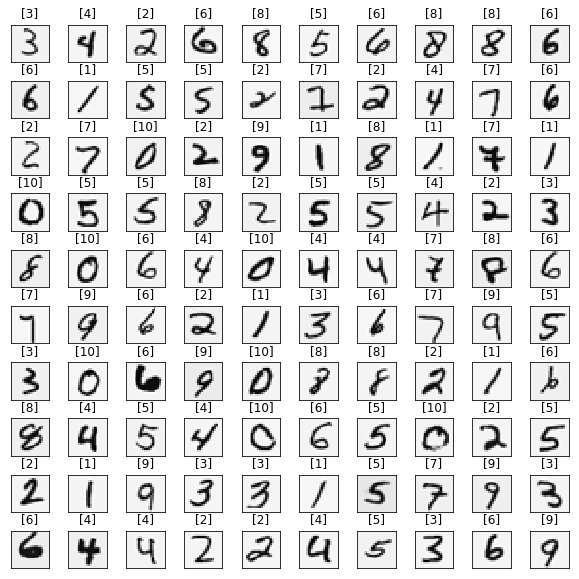

In [29]:
X=np.array([x.reshape(20,20).T for x in X ])
X=np.array([x.reshape(400) for x in X])
plot_100_image(X)

## 把y(5000,1)转化为y_onehot(5000,10)

In [30]:
encoder=OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [31]:
y_onehot[0],y[0]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([10], dtype=uint8))

In [32]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [33]:
def load_theta(path):
    data=loadmat(path)
    t1,t2=data['Theta1'],data['Theta2']
    return np.matrix(t1),np.matrix(t2)


In [34]:
t1,t2=load_theta('ex4weights.mat')
t1.shape,t2.shape

((25, 401), (10, 26))

In [35]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [36]:
theta_all=serialize(t1,t2)

In [37]:
def deserialize(theta_all):
    return theta_all[:25*401].reshape(25,401),theta_all[25*401:].reshape(10,26)

## 定义前馈函数fp

In [39]:
def fp(X,theta_all):
    theta1,theta2=deserialize(theta_all)
    a1=np.insert(X,0,np.ones(len(X)),axis=1)
    z2=a1@theta1.T
    a2=np.insert(sigmoid(z2),0,np.ones(len(z2)),axis=1)
    z3=a2@theta2.T
    h=sigmoid(z3)
    return a1,z2,a2,z3,h


### 代价函数的theta 参数需要经过serialize处理，因为这样才能方便优化函数处理

In [40]:
def cost(theta_all,X,y):
    
    _,_,_,_,h=fp(X,theta_all)
    first=np.multiply(-y,np.log(h))
    secend=np.multiply(-(1-y),np.log(1-h))
    return (first+secend).sum()/len(X)


In [42]:
cost(theta_all,X,y_onehot)

5.8303512579597223

In [43]:
def regularized_cost(theta_all,X,y,learning_rate=1):
    """
    正则化的代价函数
    """
    t1,t2=deserialize(theta_all)
    r_cost=learning_rate/2/len(X)*np.power(t1[:,1:],2).sum()+learning_rate/2/len(X)*np.power(t2[:,1:],2).sum()
    return cost(theta_all,X,y)+r_cost

In [44]:
regularized_cost(theta_all,X,y_onehot)

5.9264919518893269

## 接下来就是写梯度相关的函数

In [45]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [46]:
sigmoid_gradient(0)

0.25

In [55]:
def gradient(theta_all,X,y):
    t1,t2=deserialize(theta_all)
    a1,z2,a2,z3,h=fp(X,theta_all)
    
    detal1,detal2=np.zeros(t1.shape),np.zeros(t2.shape)
    for i in range(len(X)):
        a1i=a1[i,:] # (1,401)
        z2i=np.insert(z2[i,:],0,np.ones(1)) #(1,26)
        a2i=a2[i,:] #(1,26)
        hi=h[i,:] #(1,10)
        yi=y[i,:] #(1,10)
        
        d3=hi-yi #(1,10)
        d2=np.multiply(d3@t2, sigmoid_gradient(z2i)) #(1,26)
        
        detal1+=np.matrix(d2[1:]).T@np.matrix(a1i)
        detal2+=np.matrix(d3).T@np.matrix(a2i)
    detal1,detal2=detal1/len(X),detal2/len(X)
    return serialize(detal1,detal2)


In [56]:
gradient(theta_all,X,y_onehot).shape

(10285,)

In [57]:
def regularized_gradient(theta_all,X,y,learning_rate=1):
    t1,t2=deserialize(theta_all)
    detal1,detal2=deserialize(gradient(theta_all,X,y))
    
    detal1[:,1:]+=t1[:,1:]*learning_rate/len(X)
    detal2[:,1:]+=t2[:,1:]*learning_rate/len(X)
    
    return serialize(detal1,detal2)
    
    

In [58]:
regularized_gradient(theta_all,X,y_onehot).shape

(10285,)

## 梯度检验

In [59]:
def expand_array(arr):
    """
    将array([1,2,3])扩展成
    array([[ 1.,  2.,  3.],
          [ 1.,  2.,  3.],
          [ 1.,  2.,  3.]])
     """
    
    return np.array(np.matrix(np.ones(len(arr))).T@np.matrix(arr))

In [60]:
def gradient_checking(theta_all,X,y,epsilon,regularized=False):
    def a_numeric_grad(plus,mins,regularized):
        if regularized:
            return (regularized_cost(plus,X,y)-regularized_cost(mins,X,y))/2/epsilon
        else:
            return (cost(plus,X,y)-cost(mins,X,y))/2/epsilon
    theta_matrix=expand_array(theta_all) #expand to (10285,10285)
    epsilon_matrix=np.identity(len(theta_all))*epsilon
    
    plus_matrix=theta_all+epsilon_matrix
    minus_matrix=theta_all-epsilon_matrix
    
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i,:],minus_matrix[i,:],regularized) for i in range(len(theta_all))])
    analytic_grad = regularized_gradient(theta_all,X,y) if regularized else gradient(theta_all,X,y)
    
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('估计梯度与实际梯度的相对差距diff 应该小于 10e-9 (如果 epsilon=0.0001).\n相对差距: {}\n'.format(diff))
    
    
    

In [218]:
# gradient_checking(theta_all, X, y_onehot, epsilon=0.0001, regularized=True)      # 这个函数执行很慢

# 训练模型

In [61]:
def random_init(size):
    # 在均匀分布中随机采样
    return np.random.uniform(-0.12, 0.12, size)


## 注意，如果opt.minimize中的fun 和 jac中 的函数的第一个参数（即regularized_cost和regularized_gradient的第一个参数）不是X0,则会出错

In [62]:
def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [63]:
res=nn_training(X,y_onehot)
res

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in multiply


     fun: 0.32167830802854658
     jac: array([  1.14092084e-04,   1.78379616e-07,  -7.27556436e-08, ...,
         6.37363926e-05,   2.59073368e-06,   8.05564637e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 24
  status: 3
 success: False
       x: array([ -1.41045130e+00,   8.91898081e-04,  -3.63827933e-04, ...,
         3.15565241e-02,  -1.91393094e+00,   6.41791069e-01])

# 显示准确率

In [64]:

def show_accuracy(theta_all,X,y):
    _, _, _, _, h = fp(X, theta_all)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))


In [65]:
final_theta=res.x

y=data.get('y')
show_accuracy(final_theta,X,y)

             precision    recall  f1-score   support

          1       0.99      1.00      1.00       500
          2       0.99      0.99      0.99       500
          3       1.00      0.99      0.99       500
          4       1.00      1.00      1.00       500
          5       1.00      1.00      1.00       500
          6       1.00      1.00      1.00       500
          7       1.00      1.00      1.00       500
          8       1.00      1.00      1.00       500
          9       1.00      0.99      0.99       500
         10       0.99      1.00      1.00       500

avg / total       1.00      1.00      1.00      5000

